# **Projekt 2. Predykcja zanieczyszczenia PMx**

### Autor: Grzegorz Cichy, 405708

Zadanie polega na przeprowadzeniu analizy i predykcji szeregów czasowych dotyczących poziomu pyłu zawieszonego przy użyciu modelu XGBoost. Pył PM10 i PM2.5 to drobne cząstki stałe lub ciekłe zawieszone w powietrzu, których średnica wynosi odpowiednio 10 lub mniej i 2,5 mikrometra lub mniej. 

Zanieczyszczenie powietrza tymi cząsteczkami stanowi istotny problem dla zdrowia publicznego, ponieważ może przenikać głęboko do płuc i układu krwionośnego, co ma negatywny wpływ na zdrowie. Predykcja zawartości PMx w powietrzu pozwoli na lepsze planowanie i informowanie ludności o potencjalnych zagrożeniu.

# 1: Przygotowanie danych i inżynieria cech (20 punktów)

**Import używanych bibliotek**

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.tsa.seasonal import STL
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit


### Wczytanie danych

In [72]:
df = pd.read_excel('2019_PM25_1g.xlsx', skiprows=[0,2,3,4,5] )
stations = pd.read_excel('kody_stacji.xlsx')
df = df.rename(columns={'Kod stacji': 'timestamp',
                        'LbNaleczow':'LbNaleczAlMa',
                        'MzKonJezMos':'MzKonJezWieMOB',
                        'PdSuwPulaskp': 'PdSuwPulask2',
                        'PmGdaLeczk08':'PmGdaLeczkow',
                        'ZpSzczAndr01':'ZpSzczAndrze',
                        'ZpSzczPils02':'ZpSzczPilsud'})

df.head(5)

timestamp  DsDusznikMOB  DsJaworMOB  DsJelGorOgin  DsWrocAlWisn  \
0 2019-01-01 01:00:00      33.40530    51.38780      118.7730      102.0900   
1 2019-01-01 02:00:00      13.80280    28.49950      110.0640       63.6111   
2 2019-01-01 03:00:00       9.94056    11.12060      107.9410       48.3540   
3 2019-01-01 04:00:00       6.75889     5.57358       94.5489       34.6621   
4 2019-01-01 05:00:00       7.88722     6.56224       67.8800       14.2870   

   DsWrocWybCon  KpBydPlPozna  KpMogiNowMOB  KpToruDziewu  KpWloclOkrze  ...  \
0      107.0610       64.1177           NaN       24.0030        51.317  ...   
1       55.9187       43.8401           NaN       33.6542        30.698  ...   
2       41.3488       22.8383           NaN       13.6030        28.262  ...   
3       29.8697       20.1829           NaN       17.4302        26.522  ...   
4       17.6000       18.7345           NaN       23.0878        24.260  ...   

   SlBielPartyz  SlKatoKossut  SlZlotPotLes  WmElbBazynsk  WmGoldUzdrowMOB  \
0      110.1990       76.7306       26.3444       34.3706          14.9449   
1       73.4132       54.4664       19.0619       23.1494          10.7420   
2       50.2355       50.4599       43.7717       21.0711          12.0391   
3       37.5872       34.8090       64.0139       21.1671          13.1849   
4       22.6446       30.6517       43.6111       21.0774          14.0005   

   WmOlsPuszkin  WpKaliSawick  ZpSzczAndrze  ZpSzczBudzWosMOB  ZpSzczPilsud  
0       40.9183       75.2000           NaN               NaN      73.93500  
1       25.9358       47.9076           NaN               NaN      11.78830  
2       24.5725       22.8309       5.57095               NaN       8.69917  
3       20.6336       20.5900       5.77369               NaN       5.96861  
4       19.4194       27.0838       6.15494               NaN       7.80778  

[5 rows x 64 columns]

**Wstępne sprawdzenie wartości brakujących dla poszczególnych stacji**

In [73]:
nulls = df.isna().sum().sort_values(ascending=False)
nulls

PmGdaLeczkow        4648
ZpSzczBudzWosMOB    1620
KpToruDziewu        1547
WmElbBazynsk        1055
KpBydPlPozna         849
                    ... 
SlBielPartyz          20
MpTarRoSitko          12
PkRzeszPilsu          11
WmOlsPuszkin           2
timestamp              0
Length: 64, dtype: int64

Z powodu dużej ilości stacji, te które mają więcej niż 800 wartości brakujących są wyrzucane ze zbioru danych

In [74]:

cols_to_drop = nulls[nulls > 800].index
df = df.drop(columns=cols_to_drop)
df.head(5)

timestamp  DsDusznikMOB  DsJaworMOB  DsJelGorOgin  DsWrocAlWisn  \
0 2019-01-01 01:00:00      33.40530    51.38780      118.7730      102.0900   
1 2019-01-01 02:00:00      13.80280    28.49950      110.0640       63.6111   
2 2019-01-01 03:00:00       9.94056    11.12060      107.9410       48.3540   
3 2019-01-01 04:00:00       6.75889     5.57358       94.5489       34.6621   
4 2019-01-01 05:00:00       7.88722     6.56224       67.8800       14.2870   

   DsWrocWybCon  KpMogiNowMOB  KpWloclOkrze  LbLubObywate  LbNaleczAlMa  ...  \
0      107.0610           NaN        51.317       56.0910           NaN  ...   
1       55.9187           NaN        30.698       25.9812           NaN  ...   
2       41.3488           NaN        28.262       18.9462           NaN  ...   
3       29.8697           NaN        26.522       17.9144           NaN  ...   
4       17.6000           NaN        24.260       20.4470           NaN  ...   

   SkKielTargow  SkStaraZlota  SlBielPartyz  SlKatoKossut  SlZlotPotLes  \
0          34.6      28.46838      110.1990       76.7306       26.3444   
1          79.2      19.88634       73.4132       54.4664       19.0619   
2          25.0      16.89493       50.2355       50.4599       43.7717   
3          19.6      13.85738       37.5872       34.8090       64.0139   
4          19.6      10.45840       22.6446       30.6517       43.6111   

   WmGoldUzdrowMOB  WmOlsPuszkin  WpKaliSawick  ZpSzczAndrze  ZpSzczPilsud  
0          14.9449       40.9183       75.2000           NaN      73.93500  
1          10.7420       25.9358       47.9076           NaN      11.78830  
2          12.0391       24.5725       22.8309       5.57095       8.69917  
3          13.1849       20.6336       20.5900       5.77369       5.96861  
4          14.0005       19.4194       27.0838       6.15494       7.80778  

[5 rows x 58 columns]

In [75]:

df = df.melt(id_vars='timestamp',var_name='stacja',value_name='PM25')
df

timestamp        stacja      PM25
0      2019-01-01 01:00:00  DsDusznikMOB  33.40530
1      2019-01-01 02:00:00  DsDusznikMOB  13.80280
2      2019-01-01 03:00:00  DsDusznikMOB   9.94056
3      2019-01-01 04:00:00  DsDusznikMOB   6.75889
4      2019-01-01 05:00:00  DsDusznikMOB   7.88722
...                    ...           ...       ...
499315 2019-12-31 20:00:00  ZpSzczPilsud  19.16890
499316 2019-12-31 21:00:00  ZpSzczPilsud  19.71360
499317 2019-12-31 22:00:00  ZpSzczPilsud  20.24390
499318 2019-12-31 23:00:00  ZpSzczPilsud  24.74170
499319 2020-01-01 00:00:00  ZpSzczPilsud  36.85750

[499320 rows x 3 columns]

In [76]:
df = df.merge(stations.iloc[:,[1,3,7,8,10,13,14]],how='left',left_on='stacja',right_on='Kod stacji')
del df['Kod stacji']
df.head(5)

timestamp        stacja      PM25    Nazwa stacji Typ stacji  \
0 2019-01-01 01:00:00  DsDusznikMOB  33.40530  Duszniki-Zdrój        tło   
1 2019-01-01 02:00:00  DsDusznikMOB  13.80280  Duszniki-Zdrój        tło   
2 2019-01-01 03:00:00  DsDusznikMOB   9.94056  Duszniki-Zdrój        tło   
3 2019-01-01 04:00:00  DsDusznikMOB   6.75889  Duszniki-Zdrój        tło   
4 2019-01-01 05:00:00  DsDusznikMOB   7.88722  Duszniki-Zdrój        tło   

  Typ obszaru   Województwo  WGS84 φ N  WGS84 λ E  
0     miejski  DOLNOŚLĄSKIE  50.402645  16.393319  
1     miejski  DOLNOŚLĄSKIE  50.402645  16.393319  
2     miejski  DOLNOŚLĄSKIE  50.402645  16.393319  
3     miejski  DOLNOŚLĄSKIE  50.402645  16.393319  
4     miejski  DOLNOŚLĄSKIE  50.402645  16.393319

Procent wartości brakujących dla poszczególnych kolumn

In [77]:
nulls = df.isna().sum() / df.shape[0] * 100
nulls.sort_values(ascending=False)

PM25            2.788993
timestamp       0.000000
stacja          0.000000
Nazwa stacji    0.000000
Typ stacji      0.000000
Typ obszaru     0.000000
Województwo     0.000000
WGS84 φ N       0.000000
WGS84 λ E       0.000000
dtype: float64

### EDA

**Przebieg szeregów czasowych**

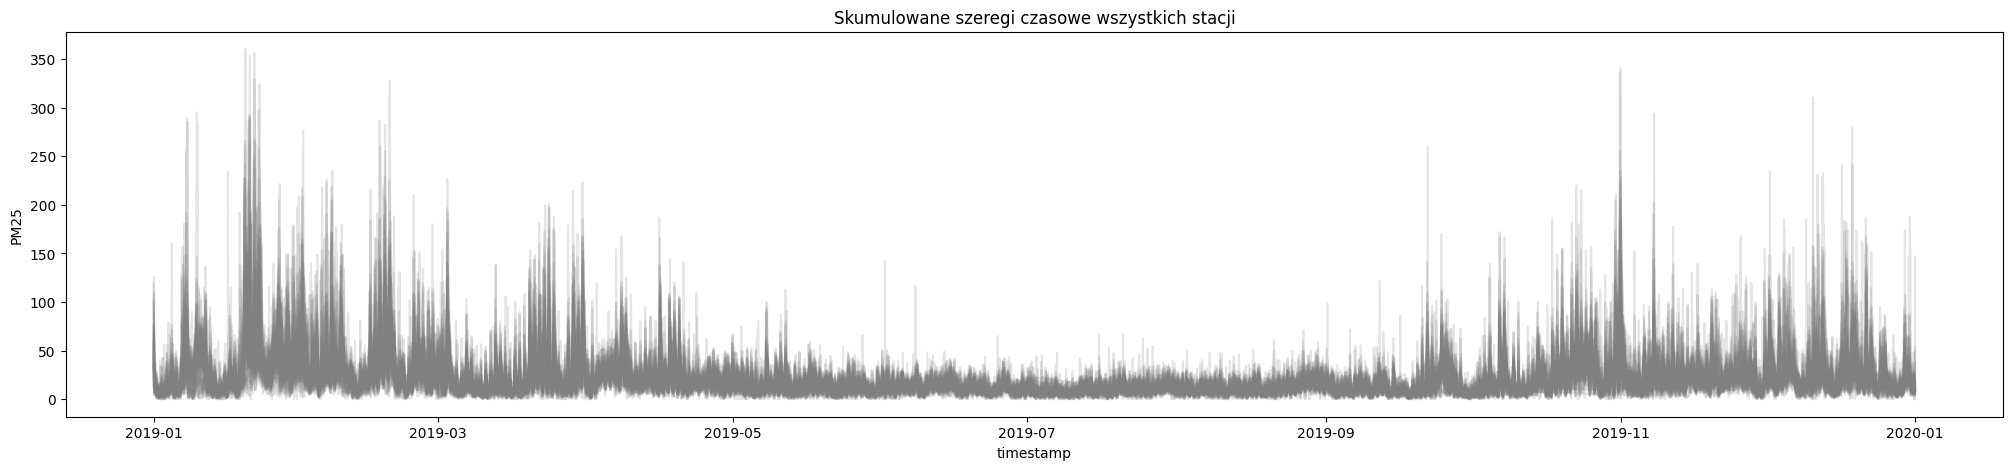

In [67]:
stations = df['stacja'].unique()
fig, ax = plt.subplots(1,1,figsize=(25,5))
for s in stations:
    sns.lineplot(x=df['timestamp'], y=df[df['stacja'] == s]['PM25'],ax=ax,data=df,alpha=0.2,color='gray')
ax.set_title('Skumulowane szeregi czasowe wszystkich stacji')
plt.show()

Celem tego wykresu było wykrycie oczywistych anomalnych stacji, dla których pomiary są błędne. Patrząc na wykres wydaje się, iż takich nie ma.

**Rozkład stężenia dla poszczególnych stacji**

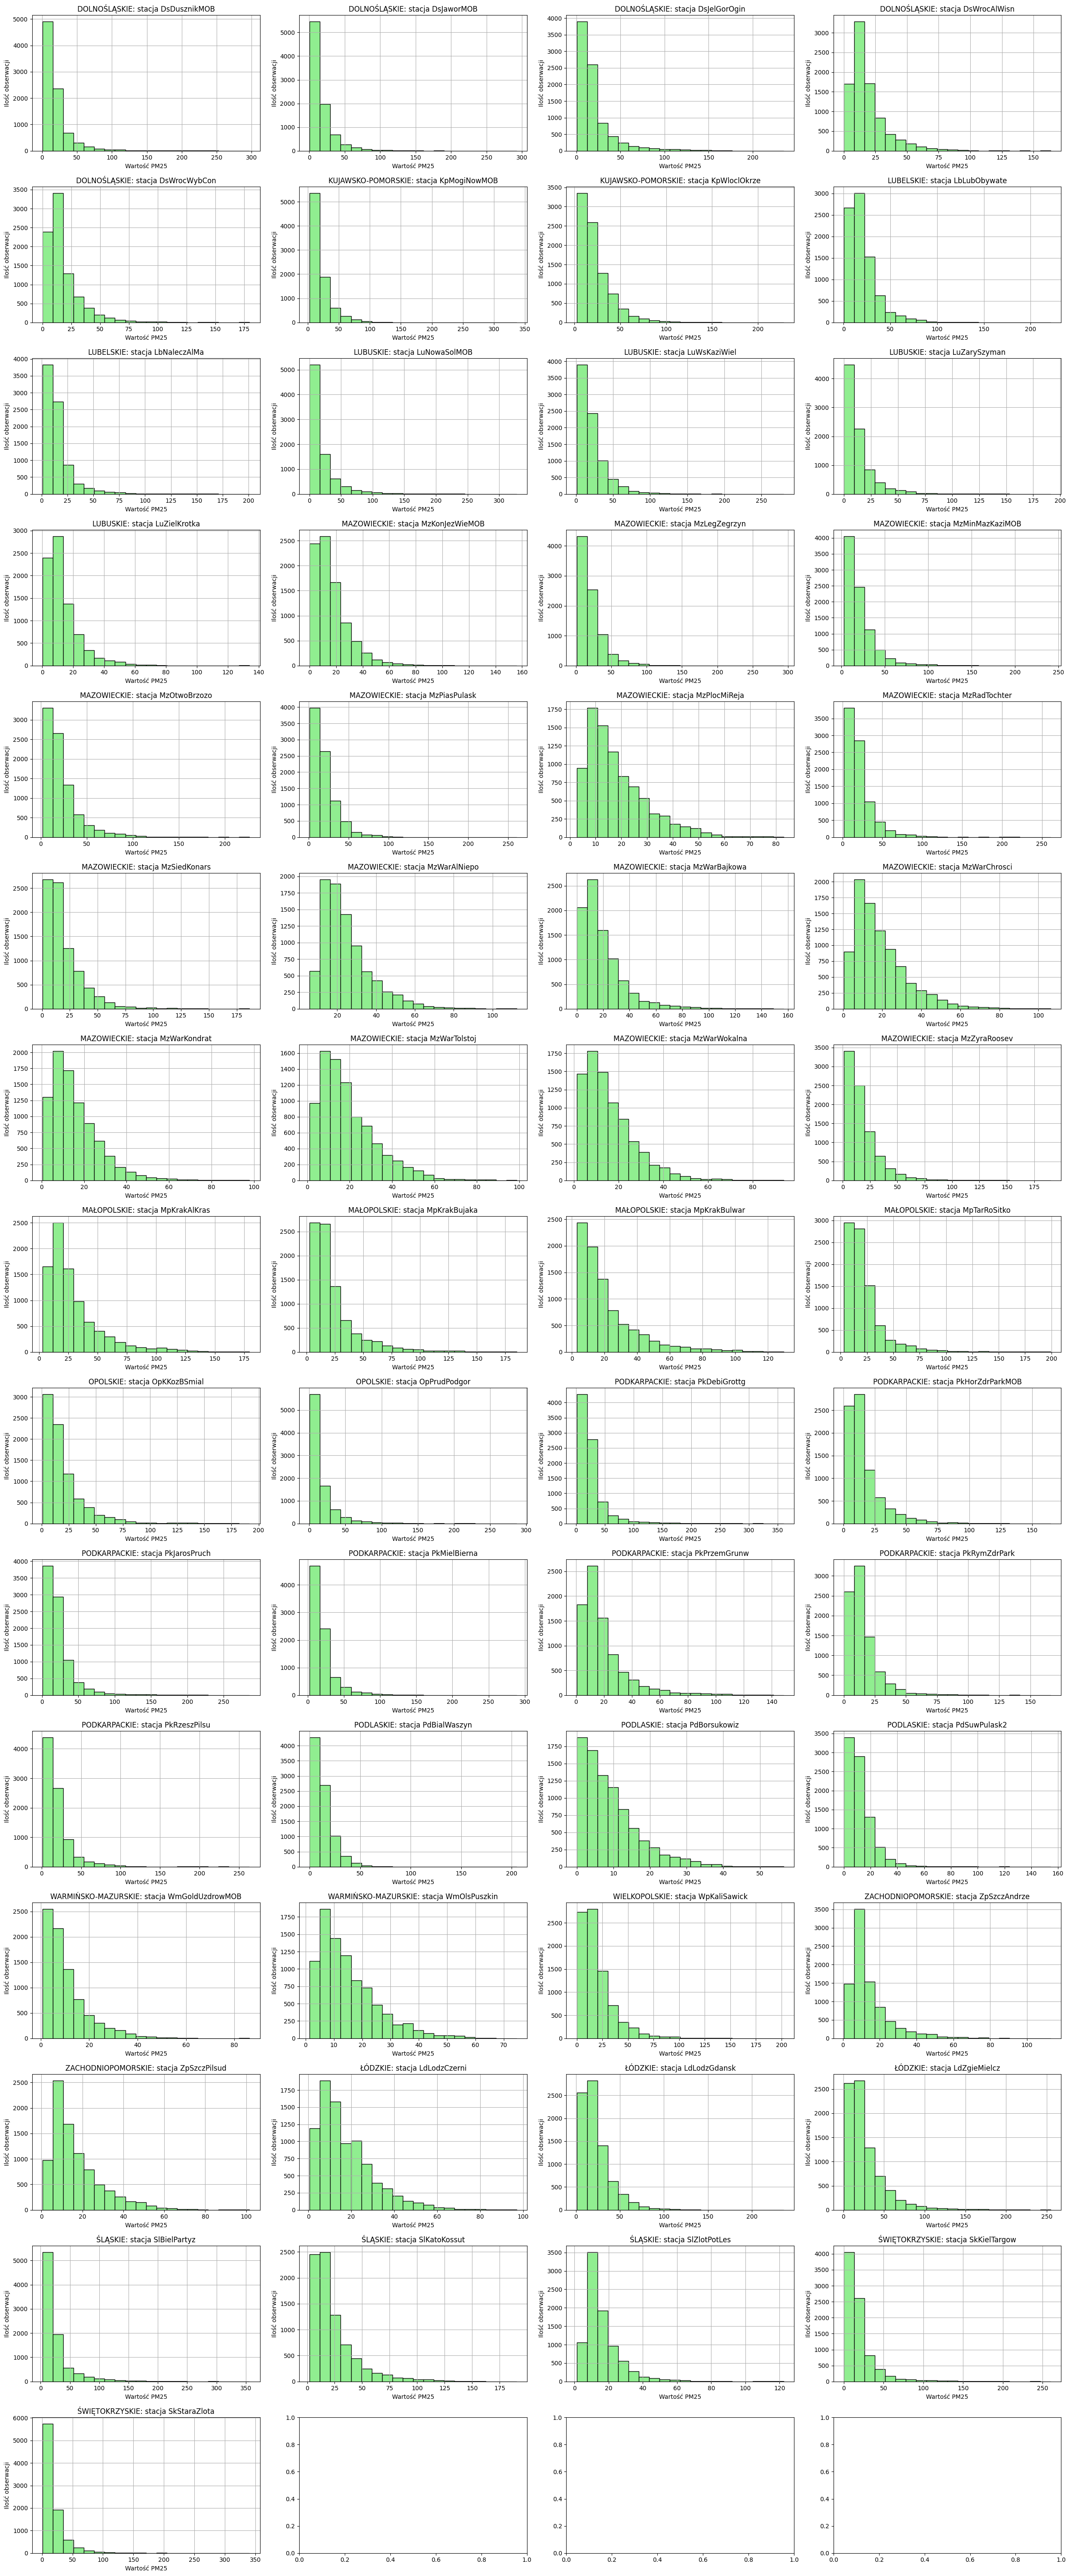

In [9]:
fig, axs = plt.subplots(15, 4, figsize=(25, 60))

unique_stations = df.sort_values(by=['Województwo','stacja'])[['Województwo','stacja']].drop_duplicates().reset_index()

for i, row in unique_stations.iterrows():

    woj = row['Województwo']
    stat = row['stacja']
    
    ax = axs.flatten()
    ax[i].hist(df[df['stacja'] == stat]['PM25'], bins = 20, color = 'lightgreen', edgecolor = 'black')
    ax[i].set_title(woj +': stacja ' + stat)
    ax[i].set_xlabel('Wartość PM25')
    ax[i].set_ylabel('Ilość obserwacji')
    ax[i].grid()

plt.tight_layout()

**Średnie godzinowe stężenia dla wszystkich stacji oraz wybranych województw**

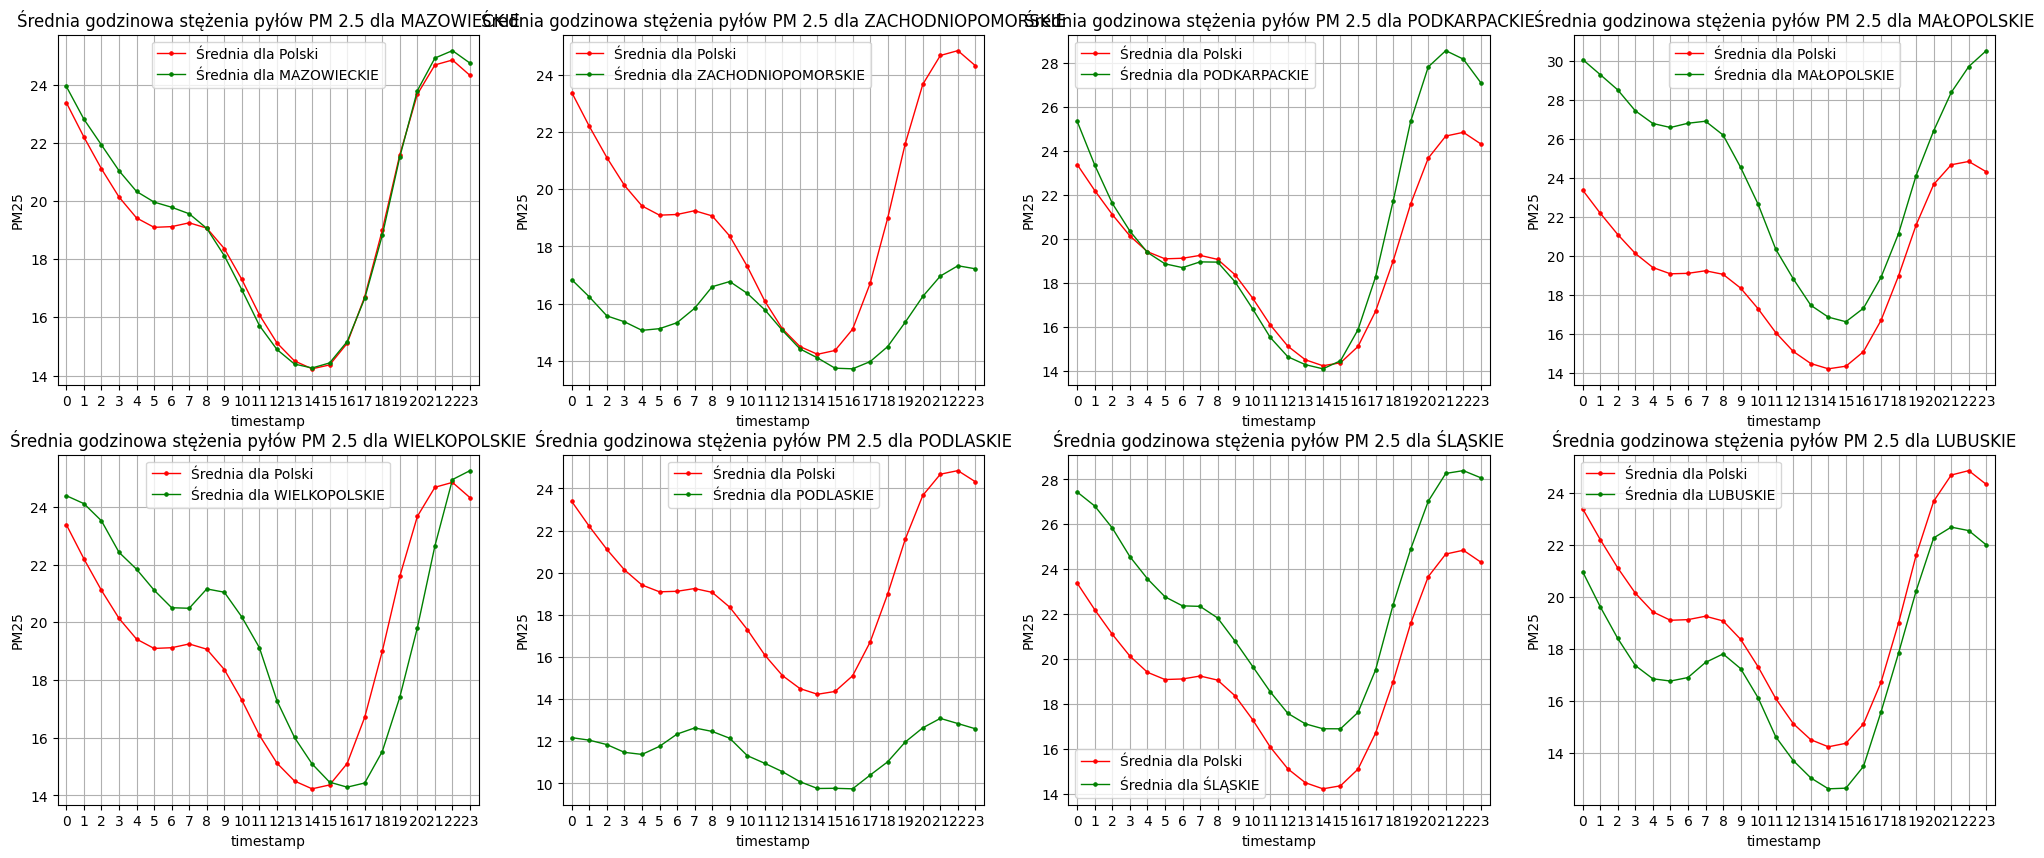

In [65]:
df_hour_reg = df.groupby([df['timestamp'].dt.hour,'Województwo'])['PM25'].mean().reset_index()

reg_list = ['MAZOWIECKIE','ZACHODNIOPOMORSKIE','PODKARPACKIE','MAŁOPOLSKIE','WIELKOPOLSKIE','PODLASKIE','ŚLĄSKIE', 'LUBUSKIE']
fig, axs = plt.subplots(2,4,figsize=(25,10))
ax = axs.flatten()   

mean_hour_pl = df.groupby(df['timestamp'].dt.hour)['PM25'].mean()
df_hour_reg = df.groupby([df['timestamp'].dt.hour,'Województwo'])['PM25'].mean().reset_index()

  

for i, reg in enumerate(reg_list):
    df_filt = df_hour_reg[df_hour_reg['Województwo'] == reg]

    sns.pointplot(data=mean_hour_pl,ax=ax[i],color='red',linewidth=1, label='Średnia dla Polski')  
    sns.pointplot(x=df_filt['timestamp'], y=df_filt['PM25'],ax=ax[i],linewidth=1,color='green', label=f'Średnia dla {reg}')
    ax[i].set_title(f'Średnia godzinowa stężenia pyłów PM 2.5 dla {reg}')
    ax[i].legend()
    ax[i].grid()
    
    
plt.show()


**Średnie miesięczne stężęnia dla wszystkich stacji i wybranych województw**

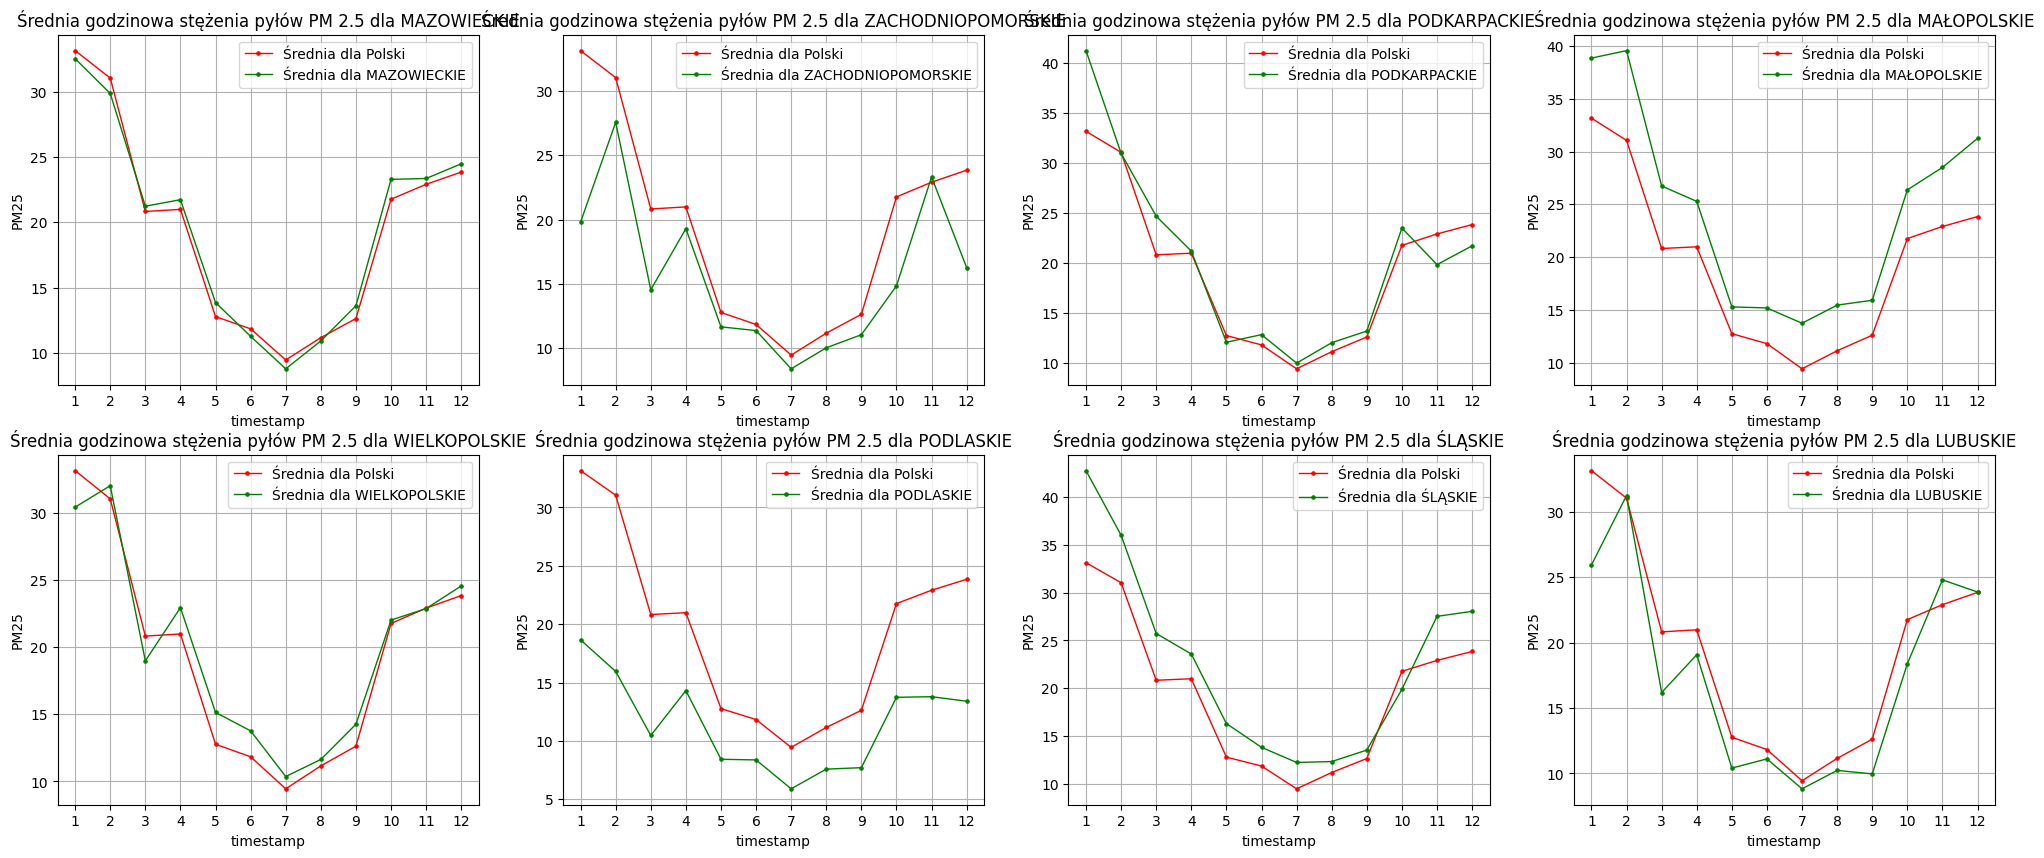

In [12]:
reg_list = ['MAZOWIECKIE','ZACHODNIOPOMORSKIE','PODKARPACKIE','MAŁOPOLSKIE','WIELKOPOLSKIE','PODLASKIE','ŚLĄSKIE', 'LUBUSKIE']
fig, axs = plt.subplots(2,4,figsize=(25,10))
ax = axs.flatten()   

mean_month_pl = df.groupby(df['timestamp'].dt.month)['PM25'].mean()
df_month_reg = df.groupby([df['timestamp'].dt.month,'Województwo'])['PM25'].mean().reset_index()

  

for i, reg in enumerate(reg_list):
    df_filt = df_month_reg[df_month_reg['Województwo'] == reg]

    sns.pointplot(data=mean_month_pl,ax=ax[i],color='red',linewidth=1, label='Średnia dla Polski',)  
    sns.pointplot(x=df_filt['timestamp'], y=df_filt['PM25'],ax=ax[i],linewidth=1,color='green', label=f'Średnia dla {reg}')
    ax[i].set_title(f'Średnia godzinowa stężenia pyłów PM 2.5 dla {reg}')
    ax[i].legend()
    ax[i].grid()
    
    
plt.show()

**Różnica między średnią dla województwa, a jego poszczególnymi stacjami**

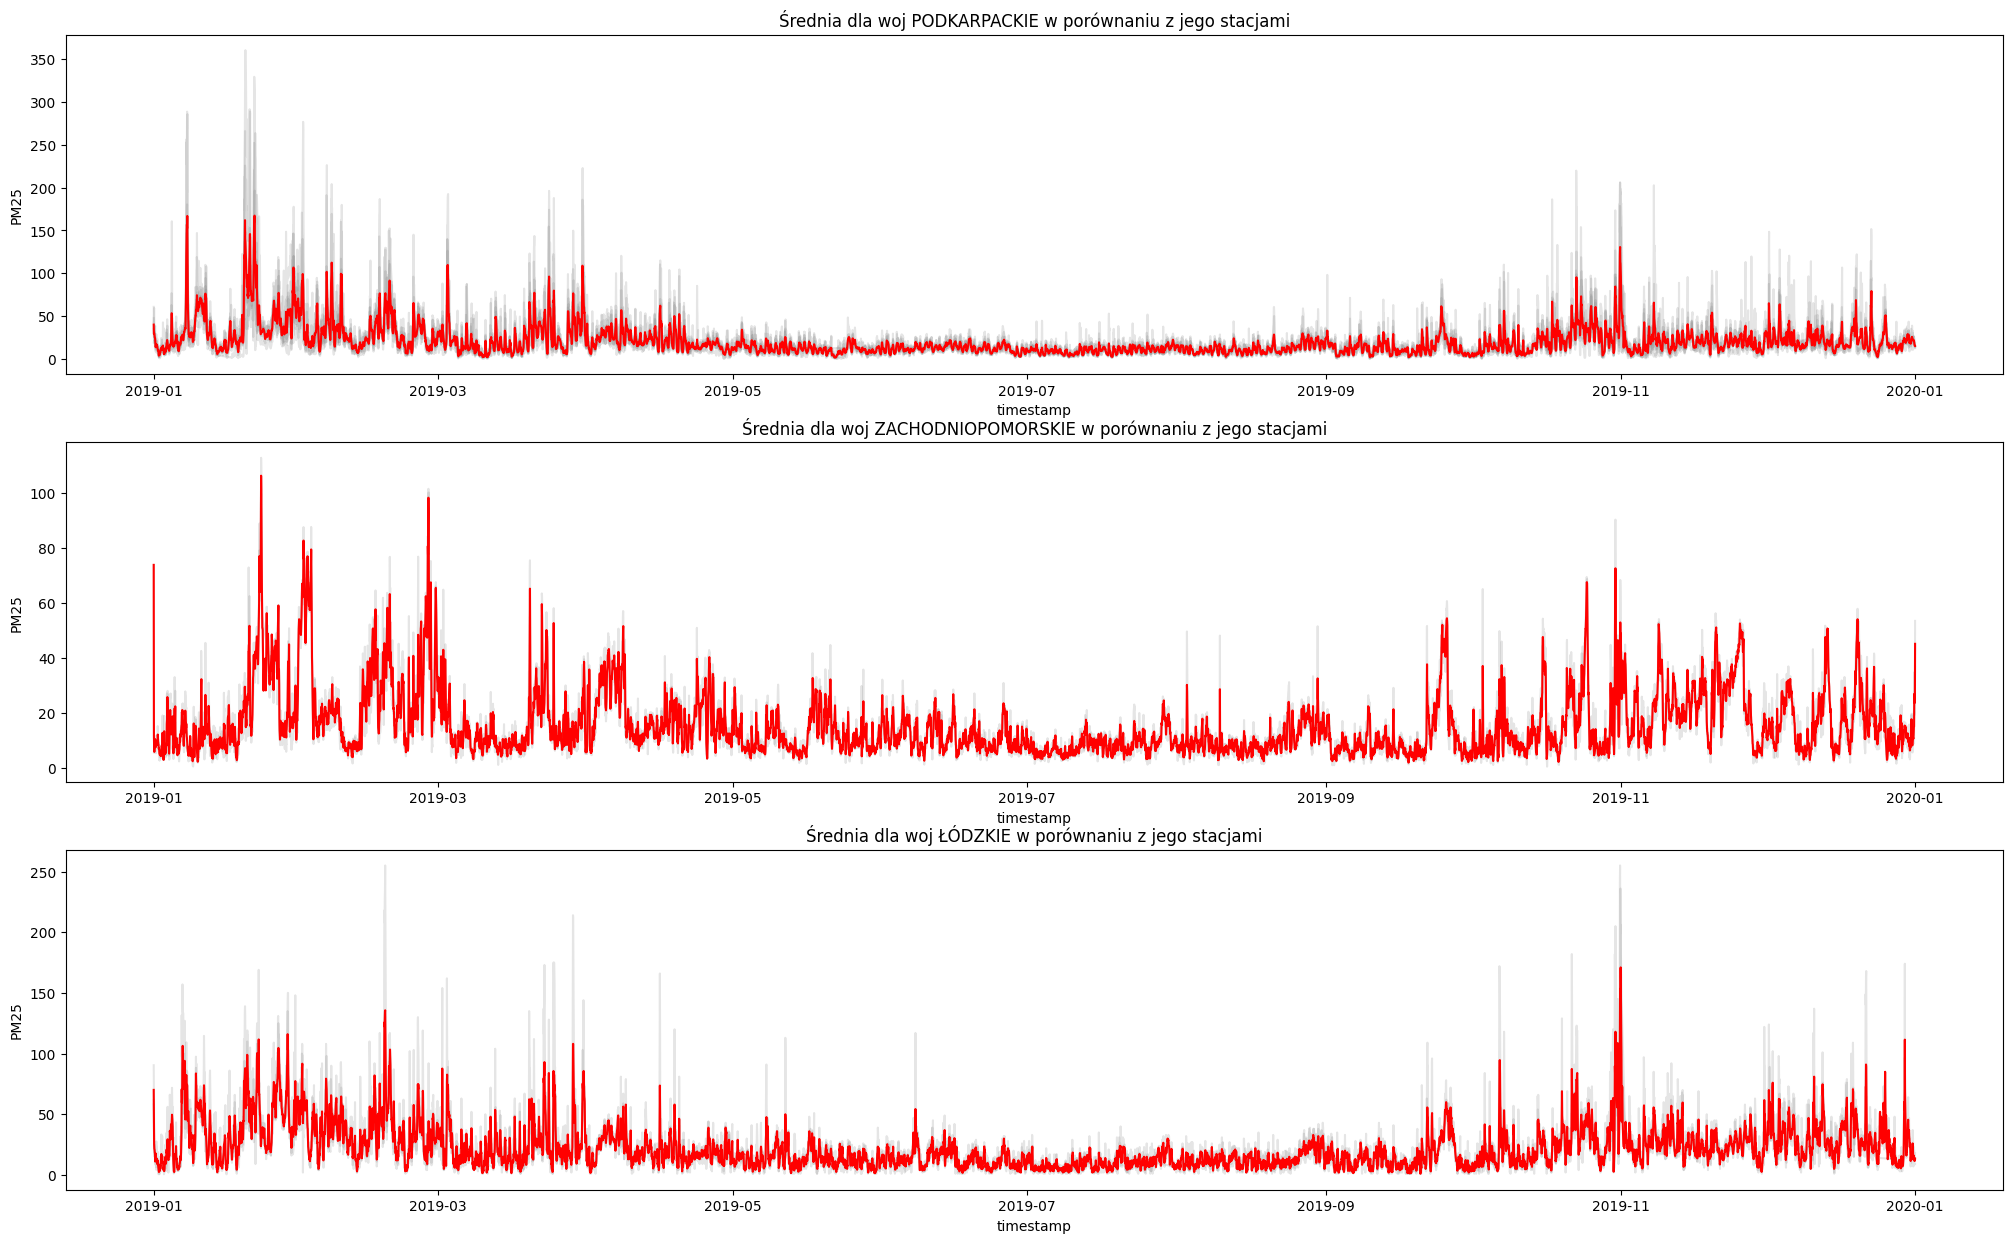

In [13]:
reg_list = ['PODKARPACKIE','ZACHODNIOPOMORSKIE','ŁÓDZKIE']
fig, ax = plt.subplots(3,1,figsize=(25,15))


for i, reg in enumerate(reg_list):
    df_filt = df[df['Województwo'] == reg]
    stations = df_filt['stacja'].unique()
    mean_for_reg = df_filt[['timestamp','PM25']].groupby(['timestamp'],as_index=False).mean()
    mean_for_reg 
    
    for s in stations:
        sns.lineplot(x=df_filt['timestamp'], y=df_filt[df_filt['stacja'] == s]['PM25'],ax=ax[i],alpha=0.2,color='gray')
    ax[i].set_title(f'Średnia dla woj {reg} w porównaniu z jego stacjami')
    sns.lineplot(x=mean_for_reg['timestamp'], y=mean_for_reg['PM25'],ax=ax[i],color='red')
    
plt.show()

Na przykładowych wykresach widać, że średnia dla województwa obrazuje przytłumiony trend dla stacji w nim leżących. Z tego powodu brakujące wartości dla poszczególnych stacji zostaną zastąpione średnią dzienną dla jego województwa. 

### Uzupełnianie wartości brakujących

Zostaną one uzupełnione wartością średnią z danej godziny dla województwa w którym położona jest stacja.

In [78]:
df['PM25'] = df['PM25'].fillna(df.groupby(['timestamp', 'Województwo'])['PM25'].transform('mean'))
df.isna().sum()

timestamp         0
stacja            0
PM25            261
Nazwa stacji      0
Typ stacji        0
Typ obszaru       0
Województwo       0
WGS84 φ N         0
WGS84 λ E         0
dtype: int64

Po tej operacji pozostało jeszcze 261 wartości brakujących. Są to przypuszczalnie obserwacje z godziny, w której wszystkie stacje w danym województwie nie zebrały wartości. Te braki zostaną zastąpione średnią dla wszystkich stacji.

In [79]:
df['PM25'] = df['PM25'].fillna(df.groupby(['timestamp'])['PM25'].transform('mean'))
df.isna().sum()

timestamp       0
stacja          0
PM25            0
Nazwa stacji    0
Typ stacji      0
Typ obszaru     0
Województwo     0
WGS84 φ N       0
WGS84 λ E       0
dtype: int64

Po tych operacjach w zbiorze nie ma już wartości brakujących. Dzięki temu można przejść dalej do inżynierii cech.

## 1.1 Tworzenie cech

Ustawienie czasu jako index w zbiorze danych:

In [80]:
df.index = df['timestamp']
del df['timestamp']
df.head(5)

stacja      PM25    Nazwa stacji Typ stacji  \
timestamp                                                                
2019-01-01 01:00:00  DsDusznikMOB  33.40530  Duszniki-Zdrój        tło   
2019-01-01 02:00:00  DsDusznikMOB  13.80280  Duszniki-Zdrój        tło   
2019-01-01 03:00:00  DsDusznikMOB   9.94056  Duszniki-Zdrój        tło   
2019-01-01 04:00:00  DsDusznikMOB   6.75889  Duszniki-Zdrój        tło   
2019-01-01 05:00:00  DsDusznikMOB   7.88722  Duszniki-Zdrój        tło   

                    Typ obszaru   Województwo  WGS84 φ N  WGS84 λ E  
timestamp                                                            
2019-01-01 01:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319  
2019-01-01 02:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319  
2019-01-01 03:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319  
2019-01-01 04:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319  
2019-01-01 05:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319

### Rolling Windows

okna o różnych rozmiarach zostaną utowrzone dla średniej oraz odchylenia standardowego

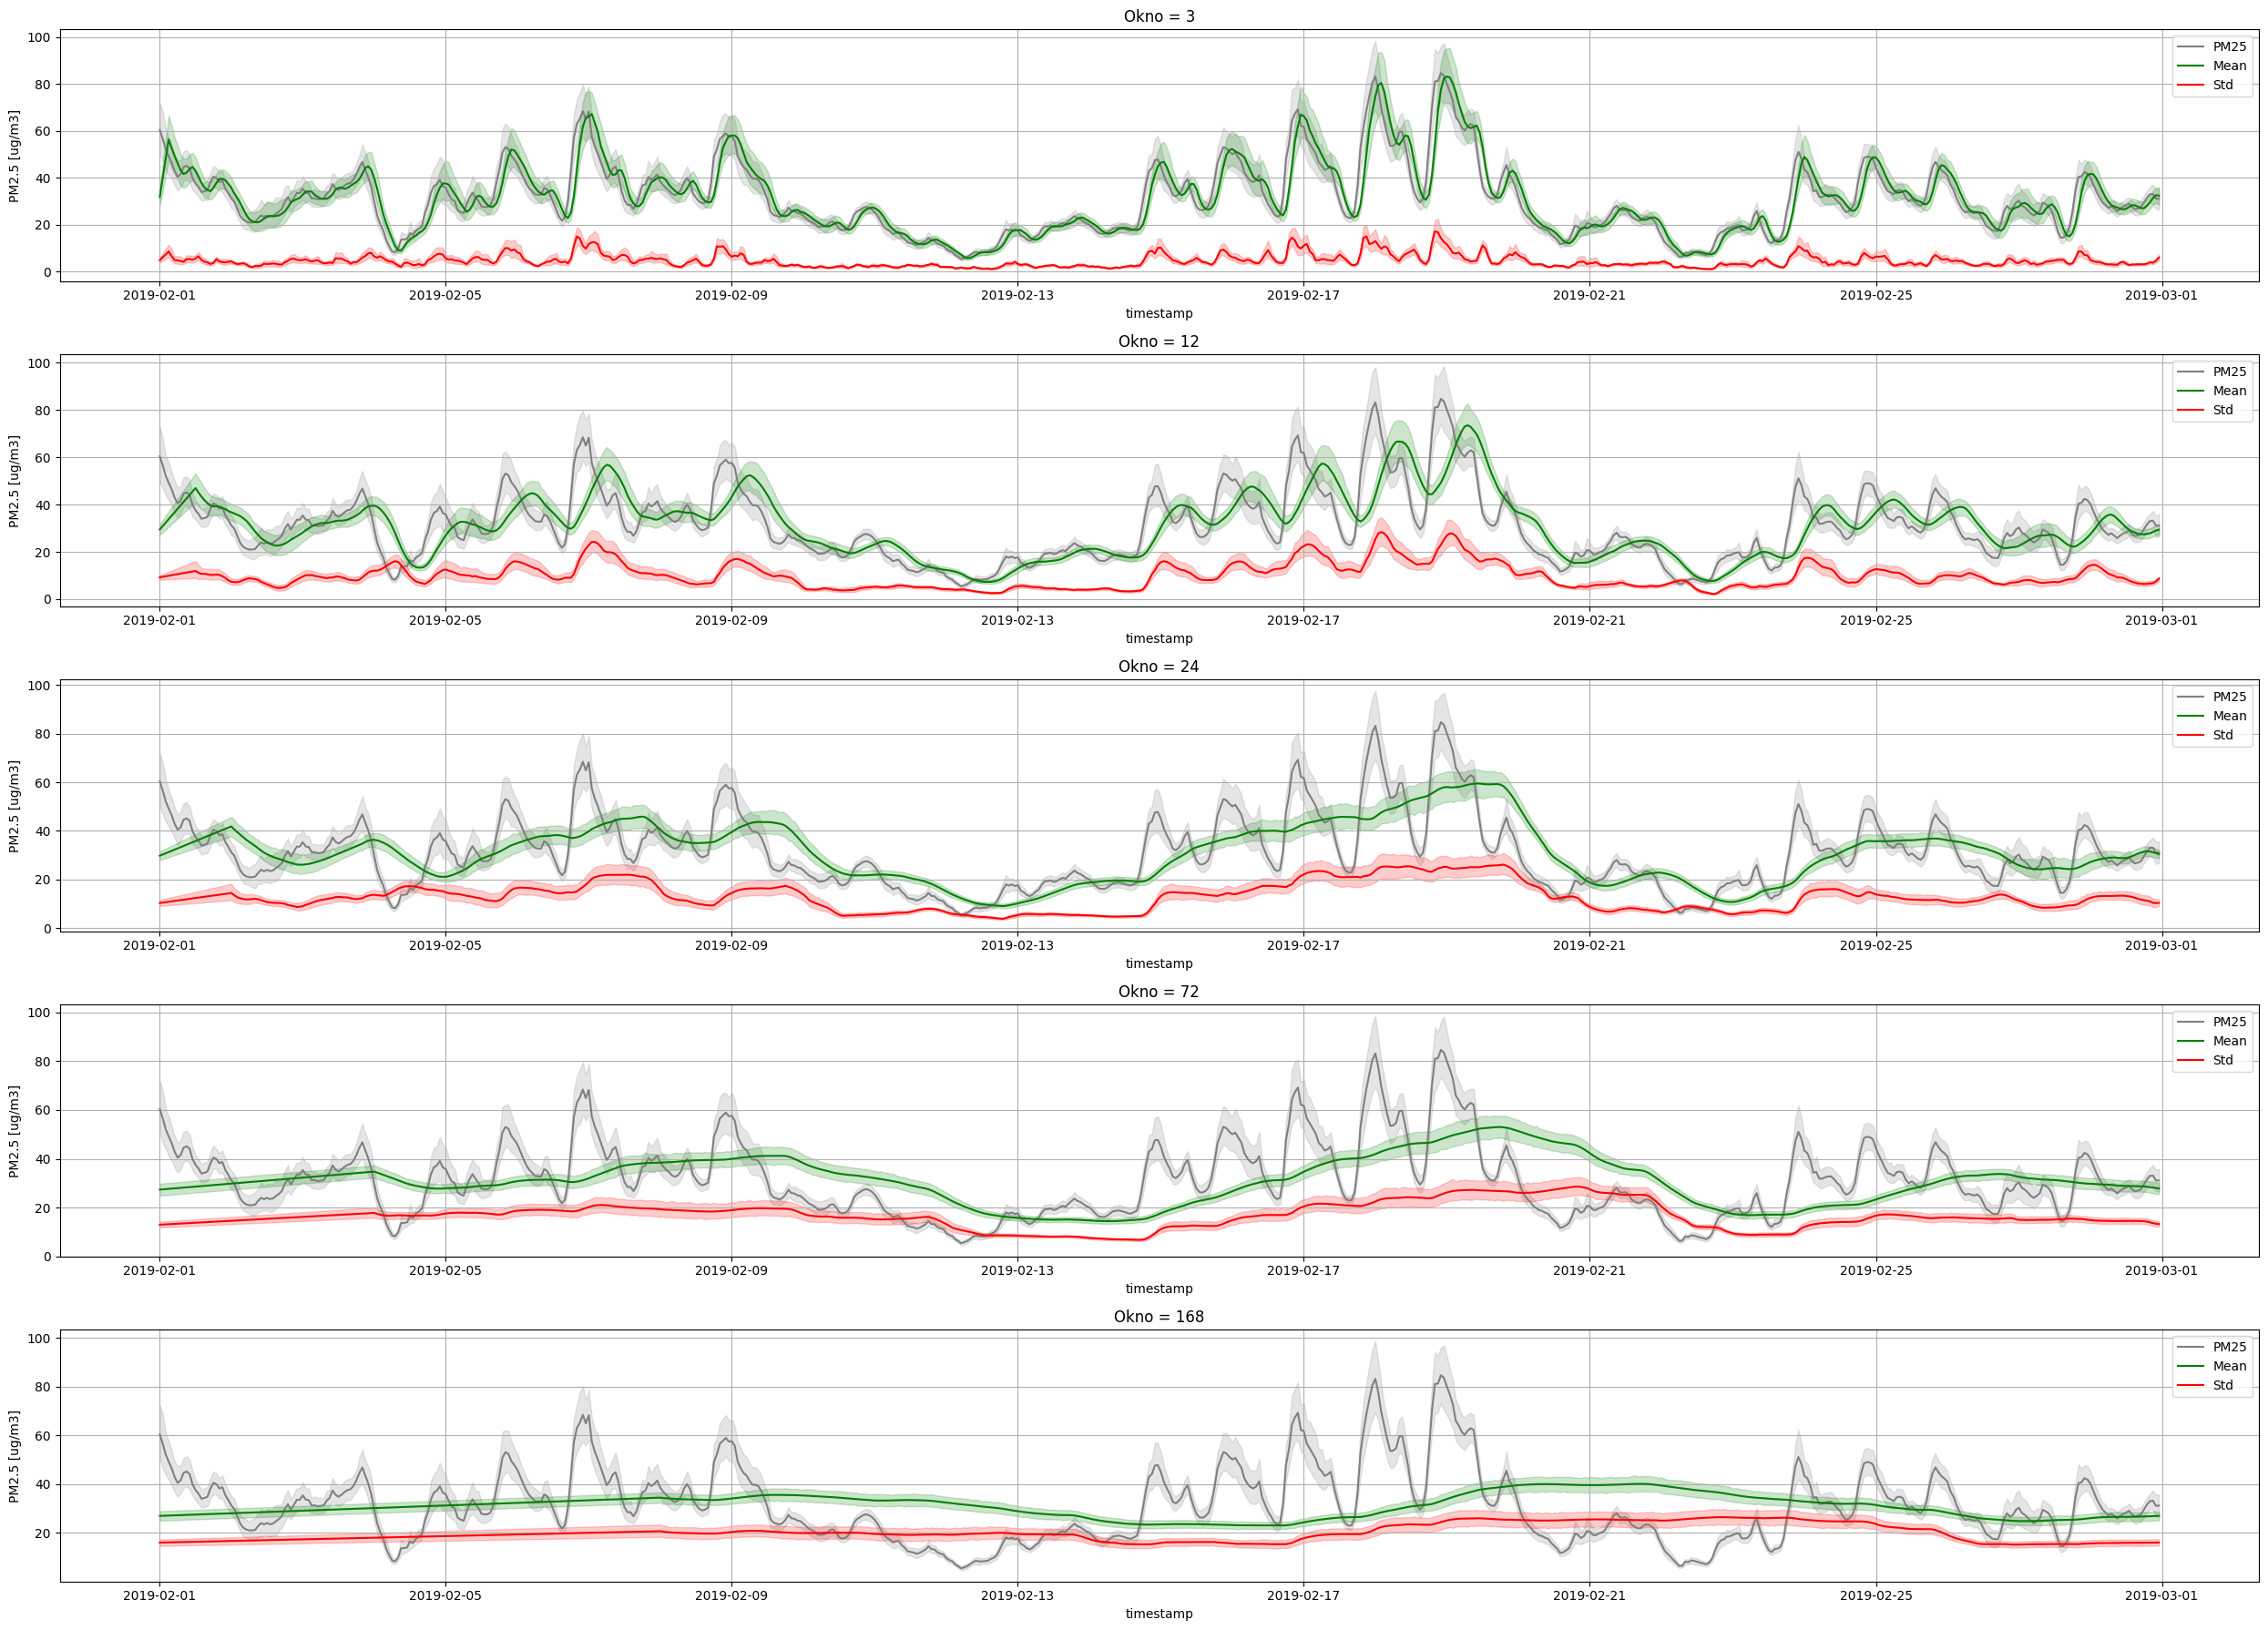

In [17]:
stats = ['mean','std']
windows = [3, 12, 24, 72, 168]
colors = ['green','orange']

df_set = df[df.index.month == 2]

fig, ax = plt.subplots(len(windows), 1, figsize = [25, 18])
for j, window in enumerate(windows):
    
    sns.lineplot(x = df_set.index, y = df_set['PM25'], ax = ax[j], color = 'grey', label = 'PM25')
    ax[j].set_title(f'Okno = {window}')
    ax[j].grid()
    # ax[i].set_xlim(np.min(data.index), np.max(data.index))
    ax[j].set_ylabel('PM2.5 [ug/m3]')
    
    rolling_mean = df_set.groupby('stacja')['PM25'].rolling(window=window).mean().shift(1).reset_index(level=0,drop=True)
    rolling_std = df_set.groupby('stacja')['PM25'].rolling(window=window).std().shift(1).reset_index(level=0,drop=True)
    
    sns.lineplot(data=rolling_mean, ax = ax[j], color = 'green', label = 'Mean')
    sns.lineplot(data=rolling_std, ax = ax[j], color = 'red', label = 'Std')

plt.tight_layout()
plt.show()

In [81]:
df['PM25_roll_mean_3'] = df.groupby('stacja')['PM25'].rolling(window=3).mean().shift(1).reset_index(level=0,drop=True)
df['PM25_roll_mean_24'] = df.groupby('stacja')['PM25'].rolling(window=24).mean().shift(1).reset_index(level=0,drop=True)
df['PM25_roll_mean_72'] = df.groupby('stacja')['PM25'].rolling(window=72).mean().shift(1).reset_index(level=0,drop=True)    
df['PM25_roll_std_12'] = df.groupby('stacja')['PM25'].rolling(window=12).std().shift(1).reset_index(level=0,drop=True)
df.head(5)

stacja      PM25    Nazwa stacji Typ stacji  \
timestamp                                                                
2019-01-01 01:00:00  DsDusznikMOB  33.40530  Duszniki-Zdrój        tło   
2019-01-01 02:00:00  DsDusznikMOB  13.80280  Duszniki-Zdrój        tło   
2019-01-01 03:00:00  DsDusznikMOB   9.94056  Duszniki-Zdrój        tło   
2019-01-01 04:00:00  DsDusznikMOB   6.75889  Duszniki-Zdrój        tło   
2019-01-01 05:00:00  DsDusznikMOB   7.88722  Duszniki-Zdrój        tło   

                    Typ obszaru   Województwo  WGS84 φ N  WGS84 λ E  \
timestamp                                                             
2019-01-01 01:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 02:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 03:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 04:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 05:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   

                     PM25_roll_mean_3  PM25_roll_mean_24  PM25_roll_mean_72  \
timestamp                                                                     
2019-01-01 01:00:00               NaN                NaN                NaN   
2019-01-01 02:00:00               NaN                NaN                NaN   
2019-01-01 03:00:00               NaN                NaN                NaN   
2019-01-01 04:00:00         19.049553                NaN                NaN   
2019-01-01 05:00:00         10.167417                NaN                NaN   

                     PM25_roll_std_12  
timestamp                              
2019-01-01 01:00:00               NaN  
2019-01-01 02:00:00               NaN  
2019-01-01 03:00:00               NaN  
2019-01-01 04:00:00               NaN  
2019-01-01 05:00:00               NaN

### Opóźnienia bazując na ACF

(-0.1, 1.1)

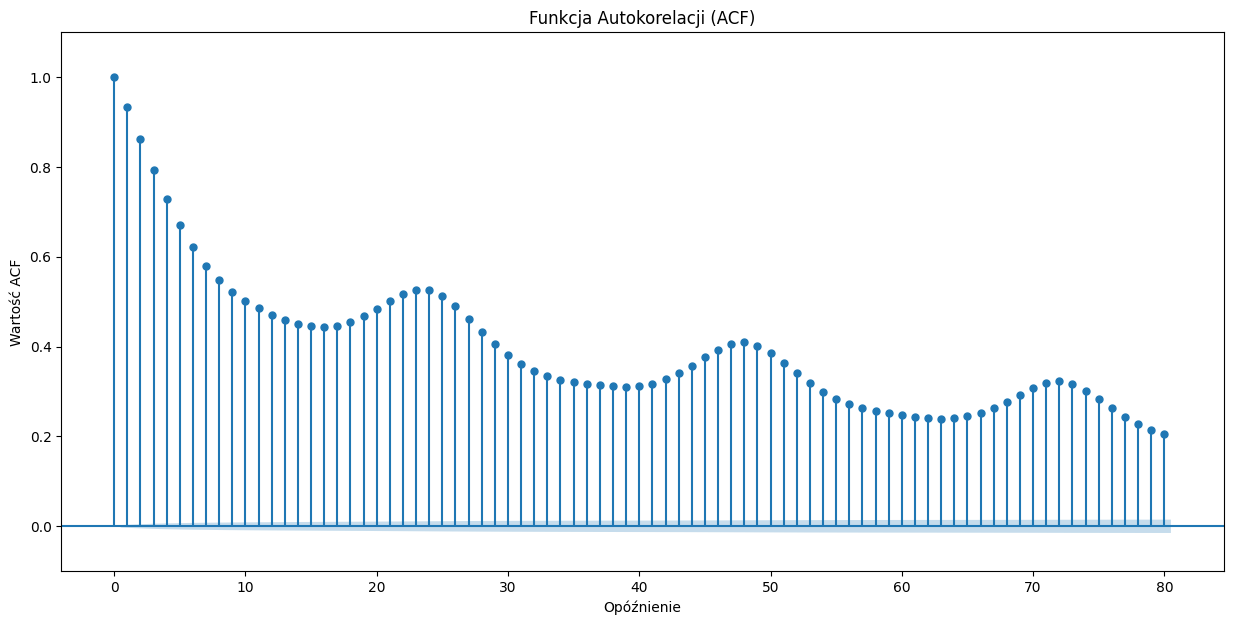

In [185]:
fig,ax = plt.subplots(1,1, figsize = (15,7))

plot_acf(df['PM25'], lags=80, ax=ax)
plt.title("Funkcja Autokorelacji (ACF)")
plt.xlabel("Opóźnienie")
plt.ylabel("Wartość ACF")
ax.set_ylim([-0.1,1.1])

Na wykresie autokorelacji widoczne są lokalne maksima dla opóźnień 24, 48 i 72. Zdecydowanie jest tu widoczny cykl dobowy. Do modelu dodane zostaną opóźnienie 24 jako posiadające najwyższą korelację ze wszystkich peaków, oraz opóźnienie o 1 godzinę, gdyż ma ono najwyższą korelację z sygnałem nieprzesuniętym.

In [82]:
df['PM25_lag_1'] = df.groupby('stacja')['PM25'].shift(1)
df['PM25_lag_24'] = df.groupby('stacja')['PM25'].shift(24)
df.head(5)

stacja      PM25    Nazwa stacji Typ stacji  \
timestamp                                                                
2019-01-01 01:00:00  DsDusznikMOB  33.40530  Duszniki-Zdrój        tło   
2019-01-01 02:00:00  DsDusznikMOB  13.80280  Duszniki-Zdrój        tło   
2019-01-01 03:00:00  DsDusznikMOB   9.94056  Duszniki-Zdrój        tło   
2019-01-01 04:00:00  DsDusznikMOB   6.75889  Duszniki-Zdrój        tło   
2019-01-01 05:00:00  DsDusznikMOB   7.88722  Duszniki-Zdrój        tło   

                    Typ obszaru   Województwo  WGS84 φ N  WGS84 λ E  \
timestamp                                                             
2019-01-01 01:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 02:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 03:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 04:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 05:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   

                     PM25_roll_mean_3  PM25_roll_mean_24  PM25_roll_mean_72  \
timestamp                                                                     
2019-01-01 01:00:00               NaN                NaN                NaN   
2019-01-01 02:00:00               NaN                NaN                NaN   
2019-01-01 03:00:00               NaN                NaN                NaN   
2019-01-01 04:00:00         19.049553                NaN                NaN   
2019-01-01 05:00:00         10.167417                NaN                NaN   

                     PM25_roll_std_12  PM25_lag_1  PM25_lag_24  
timestamp                                                       
2019-01-01 01:00:00               NaN         NaN          NaN  
2019-01-01 02:00:00               NaN    33.40530          NaN  
2019-01-01 03:00:00               NaN    13.80280          NaN  
2019-01-01 04:00:00               NaN     9.94056          NaN  
2019-01-01 05:00:00               NaN     6.75889          NaN

### Cechy związane z datą.

In [83]:
df['weekday'] = df.index.dayofweek  
df['month'] = df.index.month
df['hour'] = df.index.hour
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0) 
df.head(5)

stacja      PM25    Nazwa stacji Typ stacji  \
timestamp                                                                
2019-01-01 01:00:00  DsDusznikMOB  33.40530  Duszniki-Zdrój        tło   
2019-01-01 02:00:00  DsDusznikMOB  13.80280  Duszniki-Zdrój        tło   
2019-01-01 03:00:00  DsDusznikMOB   9.94056  Duszniki-Zdrój        tło   
2019-01-01 04:00:00  DsDusznikMOB   6.75889  Duszniki-Zdrój        tło   
2019-01-01 05:00:00  DsDusznikMOB   7.88722  Duszniki-Zdrój        tło   

                    Typ obszaru   Województwo  WGS84 φ N  WGS84 λ E  \
timestamp                                                             
2019-01-01 01:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 02:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 03:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 04:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   
2019-01-01 05:00:00     miejski  DOLNOŚLĄSKIE  50.402645  16.393319   

                     PM25_roll_mean_3  PM25_roll_mean_24  PM25_roll_mean_72  \
timestamp                                                                     
2019-01-01 01:00:00               NaN                NaN                NaN   
2019-01-01 02:00:00               NaN                NaN                NaN   
2019-01-01 03:00:00               NaN                NaN                NaN   
2019-01-01 04:00:00         19.049553                NaN                NaN   
2019-01-01 05:00:00         10.167417                NaN                NaN   

                     PM25_roll_std_12  PM25_lag_1  PM25_lag_24  weekday  \
timestamp                                                                 
2019-01-01 01:00:00               NaN         NaN          NaN        1   
2019-01-01 02:00:00               NaN    33.40530          NaN        1   
2019-01-01 03:00:00               NaN    13.80280          NaN        1   
2019-01-01 04:00:00               NaN     9.94056          NaN        1   
2019-01-01 05:00:00               NaN     6.75889          NaN        1   

                     month  hour  is_weekend  
timestamp                                     
2019-01-01 01:00:00      1     1           0  
2019-01-01 02:00:00      1     2           0  
2019-01-01 03:00:00      1     3           0  
2019-01-01 04:00:00      1     4           0  
2019-01-01 05:00:00      1     5           0

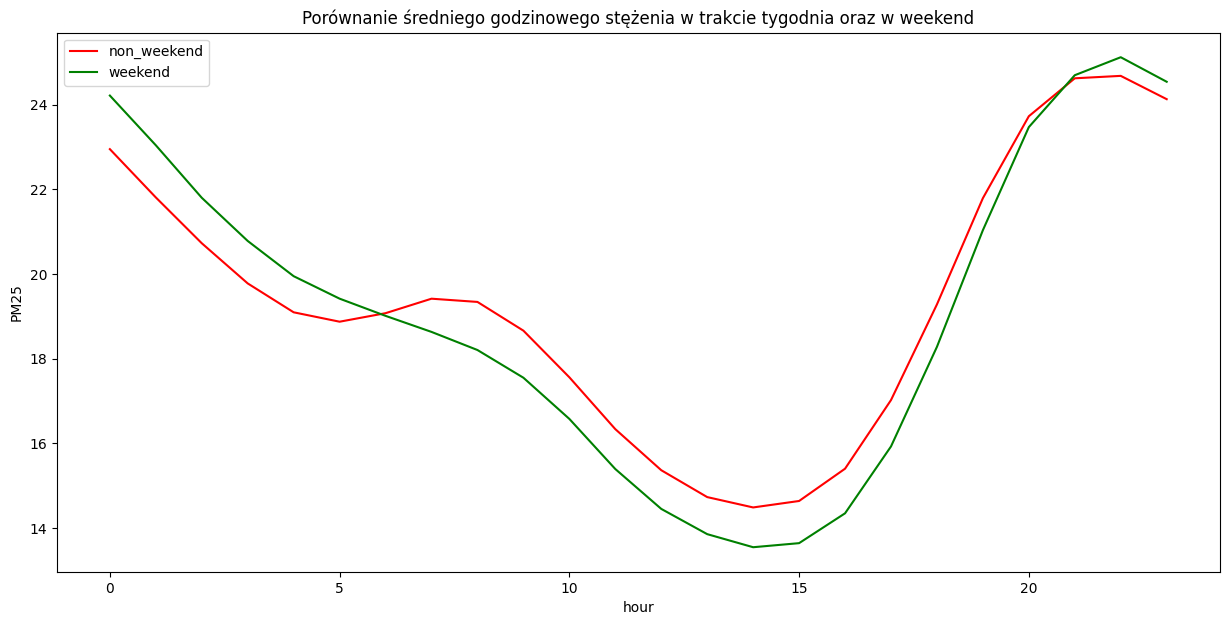

In [51]:
weekend_compare = df.groupby(['hour','is_weekend'],as_index=False)['PM25'].mean()
weekend = weekend_compare[weekend_compare['is_weekend'] == 1]
week = weekend_compare[weekend_compare['is_weekend'] == 0]
fig,ax = plt.subplots(1,1, figsize = (15,7))

sns.lineplot(x = week['hour'], y = week['PM25'], ax = ax, color = 'red', label = 'non_weekend')
sns.lineplot(x = weekend['hour'], y = weekend['PM25'], ax = ax, color = 'green', label = 'weekend')
ax.set_title('Porównanie średniego godzinowego stężenia w trakcie tygodnia oraz w weekend')
ax.legend()
plt.show()

Wybrany został dzień tygodnia, miesiąc, godzina oraz weekend. Najbardziej obiecującym parametrem wydaje się być godzina, gdyż na wykresach stworzonych w trakcie EDA wyraźnie widać trend dobowy w zależności od pory dnia. Miesiąc również może być przydatną cechą, gdyż istnieją wyraźne różnice stężenia w poszczególnych miesiącach w zależności od pory roku. Zmienne weekend i dzień tygodnia również mogą się przydać, gdyż na wykresie powyżej widoczne jest, że poziom zanieczyszczenia różni się dla dni pracujących względem weekendu. Może być to powiązane z mniejszym natężeniem ruchu w weekendy.

## 1.2 Podział zbioru danych

Przed podziałem danych na zbiory uczący i testowy przeprowadzone zostało kodowanie zmiennych kategorycznych. Oprócz tego przebudowany został indeks danych. Timestamp został posortowany, a także jako druga część indeksu dodana została stacja, w której wykonano pomiar, aby umożliwić zidentyfikowanie każdego pomiaru po podziale na zbiory.

In [84]:
from copy import deepcopy
df_enc = deepcopy(df)
df_enc.sort_index(inplace=True)
df_enc = df_enc.set_index([df_enc.index,'stacja'])


for col in df_enc.select_dtypes(exclude=['number']).columns:
    
    labelencoder = LabelEncoder()
    df_enc[col] = labelencoder.fit_transform(df_enc[col])

df_enc.head(5)
    

PM25  Nazwa stacji  Typ stacji  \
timestamp           stacja                                            
2019-01-01 01:00:00 DsDusznikMOB  33.4053             3           2   
                    LuNowaSolMOB  69.1061            23           2   
                    PkRymZdrPark  19.3000            31           2   
                    PkMielBierna  60.8821            19           2   
                    LuZarySzyman  22.4823            55           2   

                                  Typ obszaru  Województwo  WGS84 φ N  \
timestamp           stacja                                              
2019-01-01 01:00:00 DsDusznikMOB            0            0  50.402645   
                    LuNowaSolMOB            0            3  51.808662   
                    PkRymZdrPark            1            7  49.546539   
                    PkMielBierna            0            7  50.299128   
                    LuZarySzyman            0            3  51.642656   

                                  WGS84 λ E  PM25_roll_mean_3  \
timestamp           stacja                                      
2019-01-01 01:00:00 DsDusznikMOB  16.393319               NaN   
                    LuNowaSolMOB  15.708193         16.666667   
                    PkRymZdrPark  21.851006         17.366667   
                    PkMielBierna  21.440942         14.866667   
                    LuZarySzyman  15.127808         12.925737   

                                  PM25_roll_mean_24  PM25_roll_mean_72  \
timestamp           stacja                                               
2019-01-01 01:00:00 DsDusznikMOB                NaN                NaN   
                    LuNowaSolMOB          18.875000          30.736111   
                    PkRymZdrPark          19.008333          18.168056   
                    PkMielBierna          19.808333          20.401389   
                    LuZarySzyman          12.778030          17.074570   

                                  PM25_roll_std_12  PM25_lag_1  PM25_lag_24  \
timestamp           stacja                                                    
2019-01-01 01:00:00 DsDusznikMOB               NaN         NaN          NaN   
                    LuNowaSolMOB          5.299371         NaN          NaN   
                    PkRymZdrPark          3.586961         NaN          NaN   
                    PkMielBierna          3.606644         NaN          NaN   
                    LuZarySzyman          3.427998         NaN          NaN   

                                  weekday  month  hour  is_weekend  
timestamp           stacja                                          
2019-01-01 01:00:00 DsDusznikMOB        1      1     1           0  
                    LuNowaSolMOB        1      1     1           0  
                    PkRymZdrPark        1      1     1           0  
                    PkMielBierna        1      1     1           0  
                    LuZarySzyman        1      1     1           0

In [16]:
X = df_enc.drop(columns=['PM25'])
y = df_enc['PM25']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle = False)


y_train.head(10)


timestamp            stacja      
2019-01-01 01:00:00  DsDusznikMOB    33.4053
                     LuNowaSolMOB    69.1061
                     PkRymZdrPark    19.3000
                     PkMielBierna    60.8821
                     LuZarySzyman    22.4823
                     PkRzeszPilsu    34.7328
                     LdZgieMielcz    61.8320
                     MzWarChrosci    58.7946
                     ZpSzczAndrze    73.9350
                     LuZielKrotka    43.7691
Name: PM25, dtype: float64

Wizualizacja podziału na zbiór uczący i testowy dla wybranej stacji

Text(0.5, 1.0, 'Zbiory uczący i testowy dla stacji DsDusznikMOB')

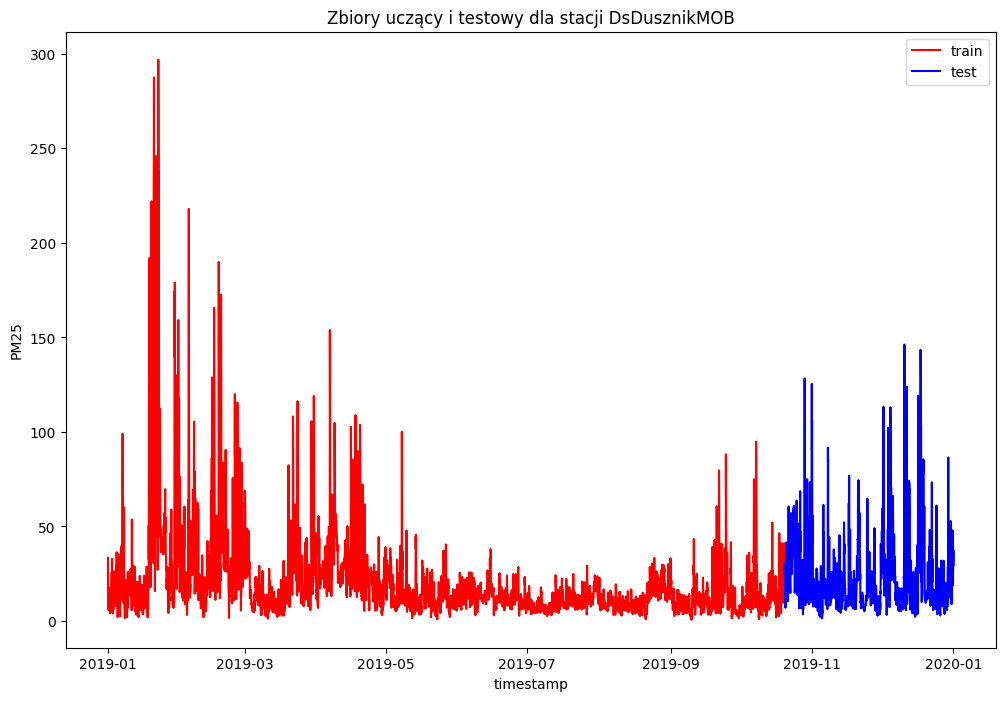

In [190]:
fig, ax = plt.subplots(1,1, figsize = [12, 8])
sns.lineplot(x=y_train.loc[(slice(None),'DsDusznikMOB')].index.get_level_values(0),y=y_train.loc[(slice(None),'DsDusznikMOB')], ax = ax, color = 'red',label = 'train')
sns.lineplot(x=y_test.loc[(slice(None),'DsDusznikMOB')].index.get_level_values(0),y=y_test.loc[(slice(None),'DsDusznikMOB')], ax = ax, color = 'blue', label = 'test')
ax.set_title('Zbiory uczący i testowy dla stacji DsDusznikMOB')

# 2: Tworzenie modelu do predykcji (20 punktów)

## 2.1 Inicjalizacja i trenowanie modelu.
Do predykcji użyty został algorytm XGB (Extreme Gradient Boosting).

In [17]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Błąd średniokwadratowy (MSE):", mse)
print("Współczynnik determinacji (R2):", r2)

Błąd średniokwadratowy (MSE): 66.863620414444
Współczynnik determinacji (R2): 0.8004360108244337


Tworząc model przy wykorzystaniu domyślnych parametrów udało się uzyskać R2 równe 0.8. Oznacza to, że model wyjaśnia 80% wariancji, co jest bardzo dobrym wynikiem.

**Plusy i minusy algorytmu predykcyjnego XGBoost w odniesieniu do szeregów czasowych**

| Zalety | Wady | 
|------------|------------|
| Dokładność wyższa niż mniej rozbudowane algorytmy | Wysoka złożoność i trudność interpretacji  |
|Łatwe dołączanie cech dodatkowych do modelu| Potrzeba przeprowadzania inżynierii cech - automatyczne tworzenie cech nie jest wbudowane |
| Możliwość radzenia sobie z wartościami brakującymi | Potrzeba tuningu hiperparametrów  |

## 2.2 Tuning hiperparametrów

Hiperparametry to parametry algorytmu, które można ustawić rozpoczęciem procesu uczenia maszynowego. Posiadają one swoje wartości domyślne, na których działa algorytm. Parametry te kontrolują zachowanie algorytmu, strukturę modelu oraz jego skuteczność. Poprzez dobranie optymalnych wartości można osiągnąć lepsze wyniki uczenia i to właśnie ma na celu tuning. Podczas tego procesu określana jest funkcja celu, która w zależności od rodzaju algorytmu może być maksymalizowana lub minimalizowana.

Pomimo niezłego wyniku uczenia dla domyślnych wartości hiperparametrów, ich tuning może pozwolić algorytmowi XGB Boost osiągnąć jeszcze lepsze wyniki dla badanego problemu.

In [40]:
# określenie parametrów, których wartości będą tuningowane
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.17],
    'max_depth': [3, 6, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 4 folds for each of 243 candidates, totalling 972 fits
Best hyperparameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
Best score:  -46.67866399956198


In [41]:
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Błąd średniokwadratowy (MSE):", mse)
print("Współczynnik determinacji (R2):", r2)

Błąd średniokwadratowy (MSE): 50.66375152868052
Współczynnik determinacji (R2): 0.8168772252294441


Tuning pomimo swojej złożoności i czasu działania, przyniósł dla wybranej siatki wartości niedużą poprawę. Być może użycie większej ilości kombinacji parametrów dałoby lepszy wynik, jednak czas wykonywania nie zachęca do dalszych eksperymentów. 

# 3: Backtesting (20 punktów)

## 3.1 Podział na okna czasowe i ocena wydajności

Metody walk-forward, roll-forward oraz gap-roll-forward validation są sposobami walidacji, które w przeciwieństwie do tradycyjnej kroswalidacji uwzględniają sekwencję czasową danych. Z tego powodu mają one zastosowanie przy tworzeniu modeli uczenia maszynowego z użyciem szeregów czasowych.
Walk-forward validation polega na iteracyjnym przesuwaniu okna treningowego i testowego przez cały zbiór danych, zachowując porządek czasowy. 

In [42]:
tscv = TimeSeriesSplit(n_splits=6)


mse_list = []
r2_list = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    r2 = r2_score(y_test, y_pred)
    r2_list.append(r2)

    print("Błąd średniokwadratowy (MSE):", mse)
    print("Współczynnik determinacji (R2):", r2)
    
print("Średni błąd średniokwadratowy (MSE) walidacji:", sum(mse_list)/len(mse_list))
print("Średni współczynnik determinacji (R2) walidacji:", sum(r2_list)/len(r2_list))

Błąd średniokwadratowy (MSE): 49.662247598633044
Współczynnik determinacji (R2): 0.8480775129247193
Błąd średniokwadratowy (MSE): 19.108154243571303
Współczynnik determinacji (R2): 0.7996063161822067
Błąd średniokwadratowy (MSE): 7.293571270946228
Współczynnik determinacji (R2): 0.7782254201660257
Błąd średniokwadratowy (MSE): 8.299417850677104
Współczynnik determinacji (R2): 0.7949149529266518
Błąd średniokwadratowy (MSE): 49.80206590755036
Współczynnik determinacji (R2): 0.8501045407551433
Błąd średniokwadratowy (MSE): 50.66375152868052
Współczynnik determinacji (R2): 0.8168772252294441
Średni błąd średniokwadratowy (MSE) walidacji: 30.80486806667643
Średni współczynnik determinacji (R2) walidacji: 0.8146343280306985


Walidacja metodą walk-forward przebiegła pomyślnie. Uśredniony MSE wynosi mniej niż dla początkowego podziału na zbiory testowe i uczące, a średni współczynnik determinacji jest równy uzyskanemu dla modelu po tuningu.

**Czym rózni się backtesting od testowania wydajności modelu dla danych niebędących szeregami czasowymi?**

- W backtestingu najważniejsza jest kolejność danych. Ze względu na pracę z szeregami czasowymi musi być ona zachowana, aby można było symulować przyszłe prognozy. W klasycznym podejściu podziały mogą być tworzone w sposób losowy.
- Przy walidacji modeli nie korzystających z szeregów czasowych zazwyczaj korzysta się z metod losowego podziału takich jak kroswalidacja, natomiast backtesting korzysta z przesuwających się okien czasowych - np. metody walk-forward, roll-forward lub gap-roll-forward validation.


# 4: Analiza istotności cech (20 punktów)

## 4.1 Wyliczenie istotności cech

In [45]:
feature_importance = best_model.feature_importances_

cols = list(X.columns)
for i, imp in enumerate(feature_importance):
    print(f"Istotność cechy {cols[i]}: {np.round(float(imp),3)}")

Istotność cechy Nazwa stacji: 0.023
Istotność cechy Typ stacji: 0.003
Istotność cechy Typ obszaru: 0.0
Istotność cechy Województwo: 0.005
Istotność cechy WGS84 φ N: 0.008
Istotność cechy WGS84 λ E: 0.005
Istotność cechy PM25_roll_mean_3: 0.006
Istotność cechy PM25_roll_mean_24: 0.037
Istotność cechy PM25_roll_mean_72: 0.01
Istotność cechy PM25_roll_std_12: 0.022
Istotność cechy PM25_lag_1: 0.83
Istotność cechy PM25_lag_24: 0.023
Istotność cechy weekday: 0.005
Istotność cechy month: 0.01
Istotność cechy hour: 0.013
Istotność cechy is_weekend: 0.0


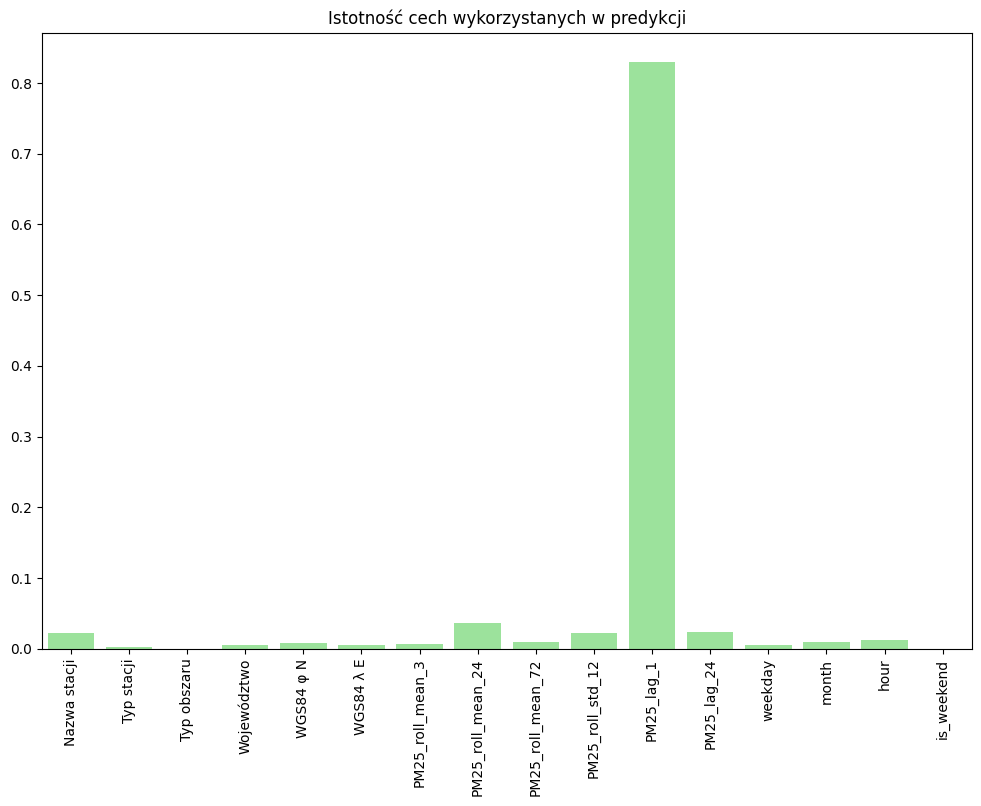

In [46]:
fig, ax = plt.subplots(1,1, figsize = [12, 8])
sns.barplot(data=feature_importance, ax = ax, color = 'lightgreen')
ax.set_title('Istotność cech wykorzystanych w predykcji')
plt.xticks(ticks=range(len(feature_importance)), labels=cols)
plt.tick_params(axis='x',rotation=90)

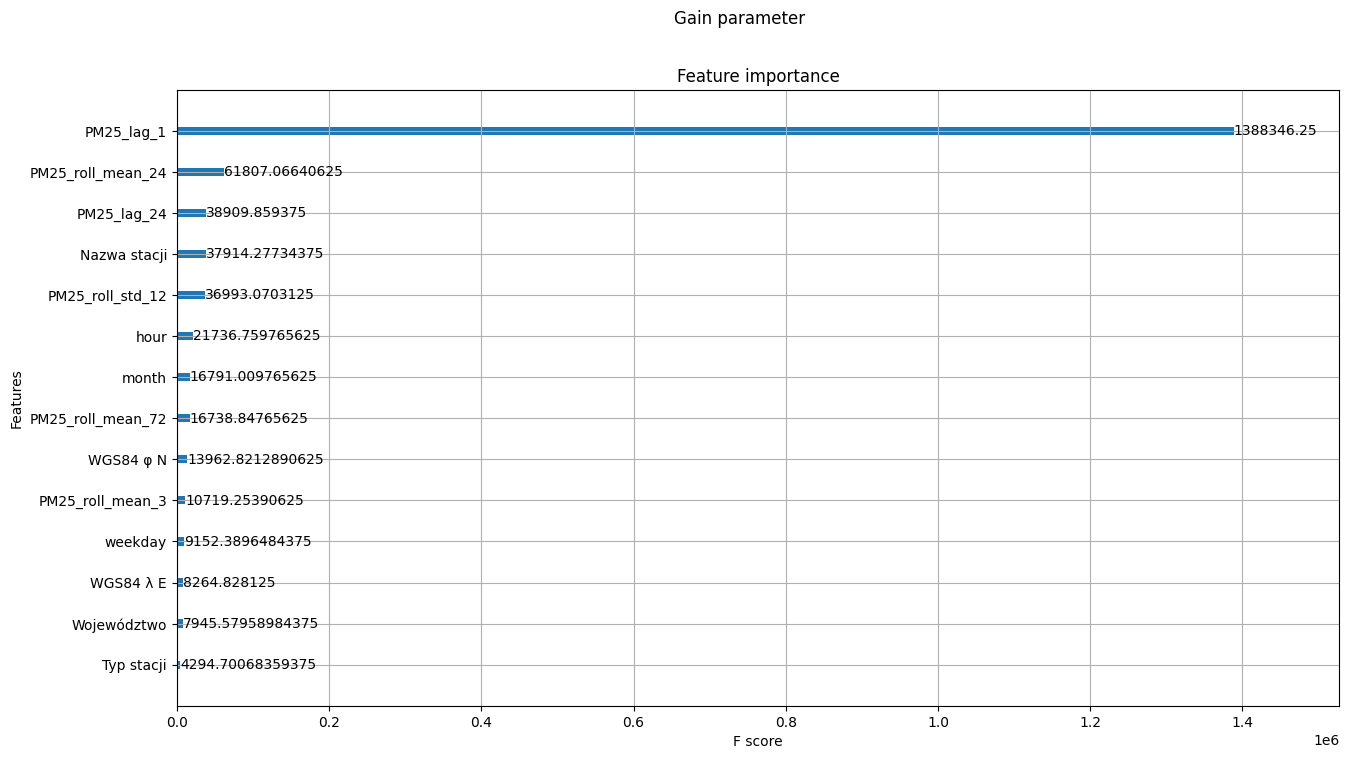

In [50]:
fig, ax = plt.subplots(1,1, figsize = [15, 8])
xgb.plot_importance(best_model, importance_type='gain',ax=ax)  # Możesz zmienić na 'weight' lub 'cover'
plt.suptitle('Gain parameter')
plt.show()

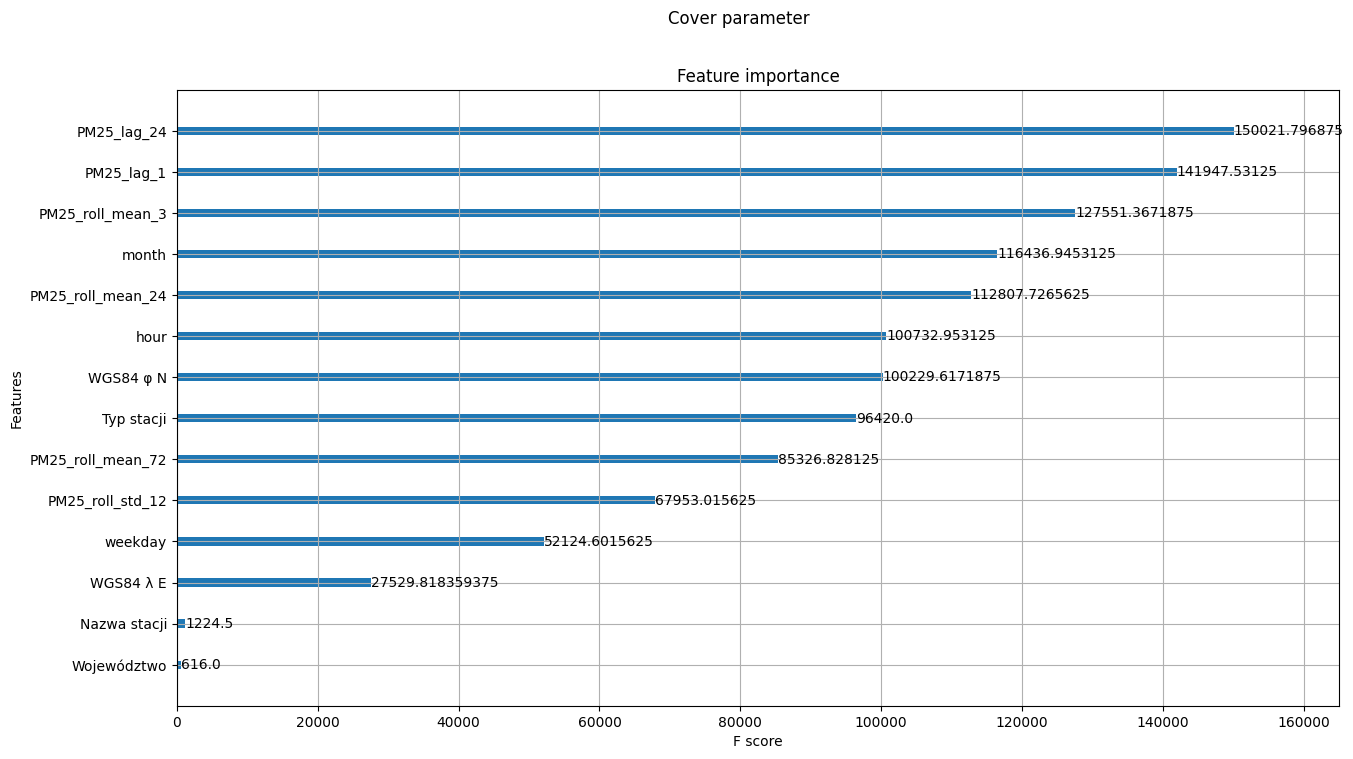

In [51]:
fig, ax = plt.subplots(1,1, figsize = [15, 8])
xgb.plot_importance(best_model, importance_type='cover',ax=ax)  # Możesz zmienić na 'weight' lub 'cover'
plt.suptitle('Cover parameter')
plt.show()

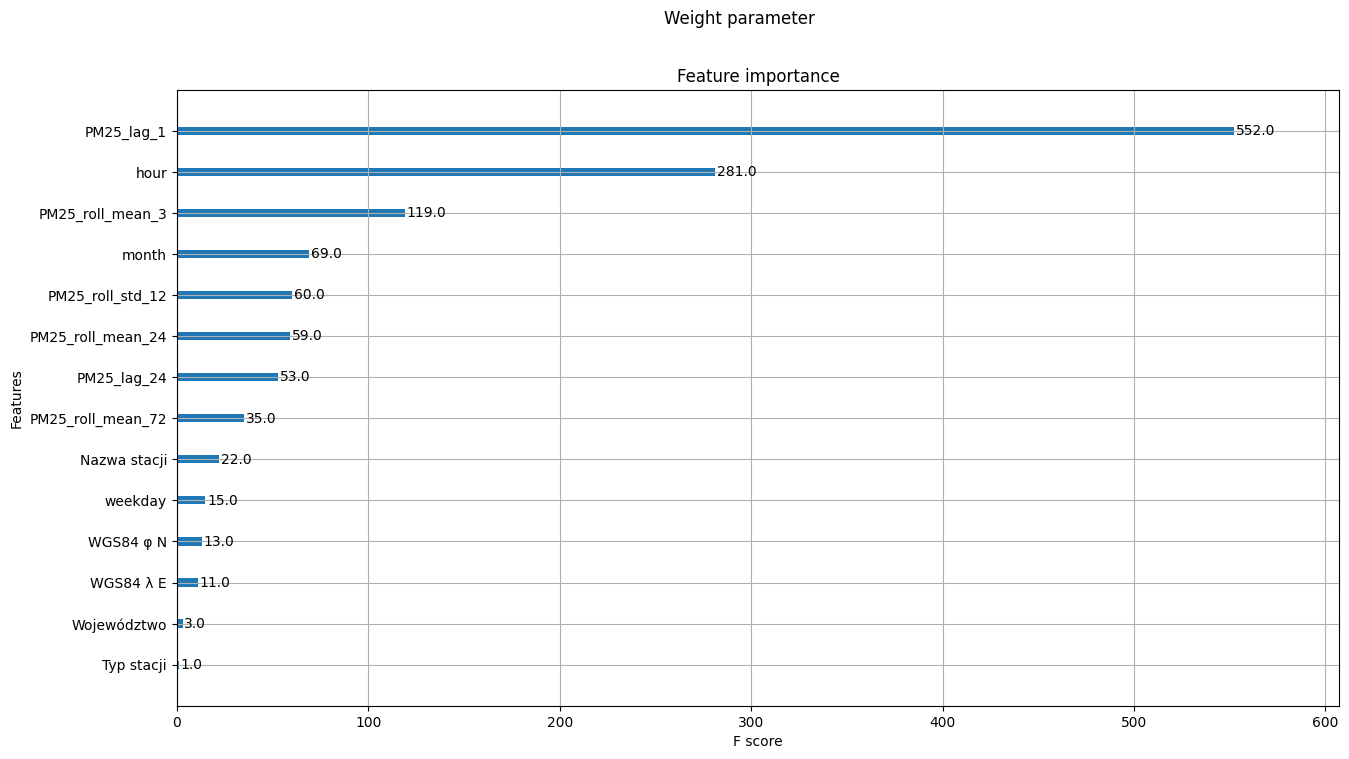

In [52]:
fig, ax = plt.subplots(1,1, figsize = [15, 8])
xgb.plot_importance(best_model, importance_type='weight', ax=ax)  # Możesz zmienić na 'weight' lub 'cover'
plt.suptitle('Weight parameter')
plt.show()

## 4.2 Interpretacja wyników

Spośród wszystkich cech używanych przez algorytm XGBoost w procesie treningu jeden z nich miał zdecydowanie największy wpływ na końcowe działanie modelu. Jest to zmienna PM25_lag_1, który jest godzinnym opóźnieniem sygnału. Jego istotność oceniona jest na ponad 0.8, co oznacza, że istotność pozostałych parametrów w sumie wynosi zaledwie 0.2.

Oprócz ogólnej istotności cech wykorzystanych w predykcji, utworzone zostały wykresy dla poszczególnych miar istotności cech:
- Gain - Średni przyrost dokładności, jaki wprowadza cecha przy każdym podziale drzewa decyzyjnego. Im wyższa wartość, tym bardziej cecha przyczynia się do poprawy modelu. <br> Dla parametru Gain jeszcze lepiej widoczny jest kluczowy wpływ cechy PM25_lag_1 na poprawę jakości modelu. <br><br>
- Cover - Średnia liczba obserwacji przetwarzanych przez cechę, kiedy jest używana do podziału. Im wyższa wartość, tym częściej cecha jest wykorzystywana do przetwarzania większej ilości próbek. <br> Dla tego parametru nie ma już aż tak ogromnej przewagi parametru godzinnego opóźnienia względem pozostałych. Widoczne jest, że inne parametry również często przetwarzają dużo obserwacji jeśli są używane do podziału drzewa. Mimo to, jak widać na wykresie 'Gain', nie przekłada się to na ich dużą istotność w poprawie działania modelu. <br><br>

- Weight - liczba razy, kiedy cecha była używana do podziału. Wyższa wartość Frequency oznacza, że cecha była częściej wybierana do podziału drzew. <br> Ten wykres również informuje, że PM25_lag_1 był najczęściej wybiernay do podziału drzew, ale inne parametry również były wybierane z podobną częstotliwością. Podobnie jak na wykresie 'Cover', widoczne jest, że duża liczba podziałów z użyciem cech innych niż godzinne opóźnienie, nie przekłada się na znaczącą poprawę jakości modelu.



Podsumowując, udało się utworzyć model, który bardzo dobrze radzi sobie z predykcją przyszłych wartości stężenia pyłów PM 2.5 - współczynnik determinacji na poziomie 82%. Ma on jednak swoje słabe strony, a najważniejszą z nich jest fakt, że opiera się on de facto na 1 cesze - godzinnym opóźnieniu, bez którego model z pewnością radziłby sobie zdecydowanie gorzej.

Porównanie wartości rzeczywistych z predykowanymi

Text(0.5, 1.0, 'wartości w zbiorze testowym vs predykcja modelu')

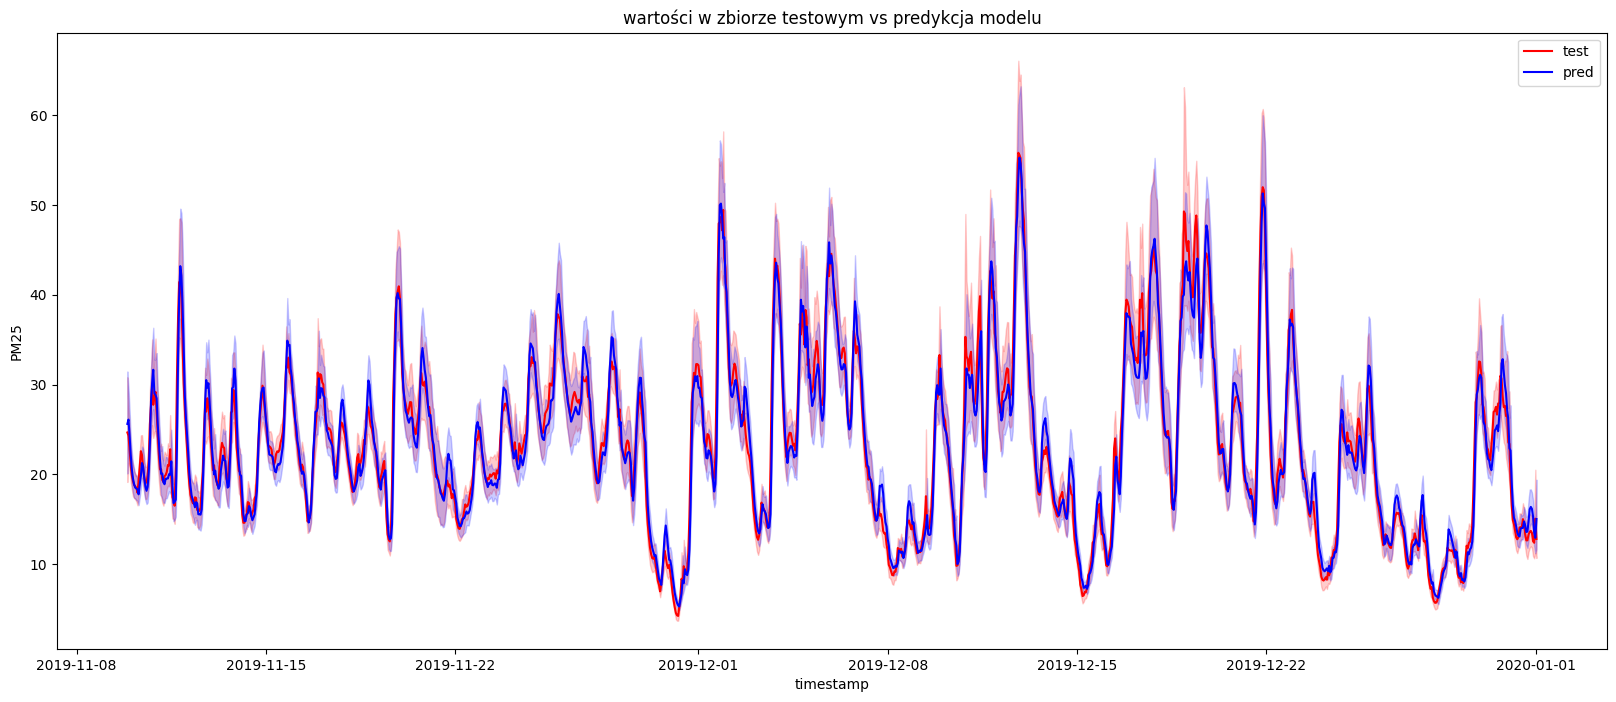

In [57]:
fig, ax = plt.subplots(1,1, figsize = [20, 8])
sns.lineplot(x=y_test.index.get_level_values(0), y=y_test, ax = ax, color = 'red',label = 'test')
sns.lineplot(x=y_test.index.get_level_values(0), y=y_pred, ax = ax, color = 'blue', label = 'pred')
ax.set_title('wartości w zbiorze testowym vs predykcja modelu')

Podsumowując, model bardzo dobrze przewiduje trend poziomu zanieczyszczenia pyłami PM 2.5 dla danych testowych, choć występują pewnie przeszacowania/niedoszacowania w lokalnych maksimach/minimach.